#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from lightgbm import LGBMRegressor
from hyperopt import hp, fmin, tpe, rand, STATUS_OK, Trials
from hyperopt.pyll.base import scope
import numpy as np
import math
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.stats import boxcox
from statsmodels.tsa.statespace import sarimax
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(0)

## Подготовка

In [3]:
try:
    data = pd.read_csv('datasets/taxi.csv', index_col = 'datetime')
except FileNotFoundError: 
    data = pd.read_csv('/datasets/taxi.csv', index_col = 'datetime')

In [4]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [5]:
data.sort_index(inplace=True)
data.index = data.index.astype('datetime64[ns]')
data_1h = data.resample('1h').sum()
data_1D = data.resample('1D').sum()
data_func = data_1h.copy()

In [6]:
data_1h

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [7]:
data_1h.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

### Анализ на стационарность
* Будем использовать тест Дики-Фуллера, а также визульный анализ.
* Нулевая гипотеза - ряд нестационарный.

In [8]:
def test_stationarity(y):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(y)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [9]:
def tsplot(y, lags=None, figsize=(15, 30), style='bmh'):
    if not isinstance(y, pd.DataFrame):
        y = pd.DataFrame(y)
        
    test_stationarity(y)
    decomposed = seasonal_decompose(y)
    
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (9, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)

        seas_ax = plt.subplot2grid(layout, (2, 0))
        trend_ax = plt.subplot2grid(layout, (3, 0))
        resid_ax = plt.subplot2grid(layout, (4, 0))

        acf_ax = plt.subplot2grid(layout, (5, 0))
        pacf_ax = plt.subplot2grid(layout, (6, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        decomposed.seasonal.plot(ax=seas_ax, color='blue', label='Or')
        seas_ax.set_title('Seasonal')

        decomposed.trend.plot(ax=trend_ax, color='blue', label='Or')
        trend_ax.set_title('Trend')

        decomposed.resid.plot(ax=resid_ax, color='blue', label='Or')
        resid_ax.set_title('Rasid')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        

        plt.tight_layout()
        plt.show()

Results of Dickey-Fuller Test:
Test Statistic                   -3.068924
p-value                           0.028940
#Lags Used                       30.000000
Number of Observations Used    4385.000000
Critical Value (1%)              -3.431842
Critical Value (5%)              -2.862199
Critical Value (10%)             -2.567121
dtype: float64


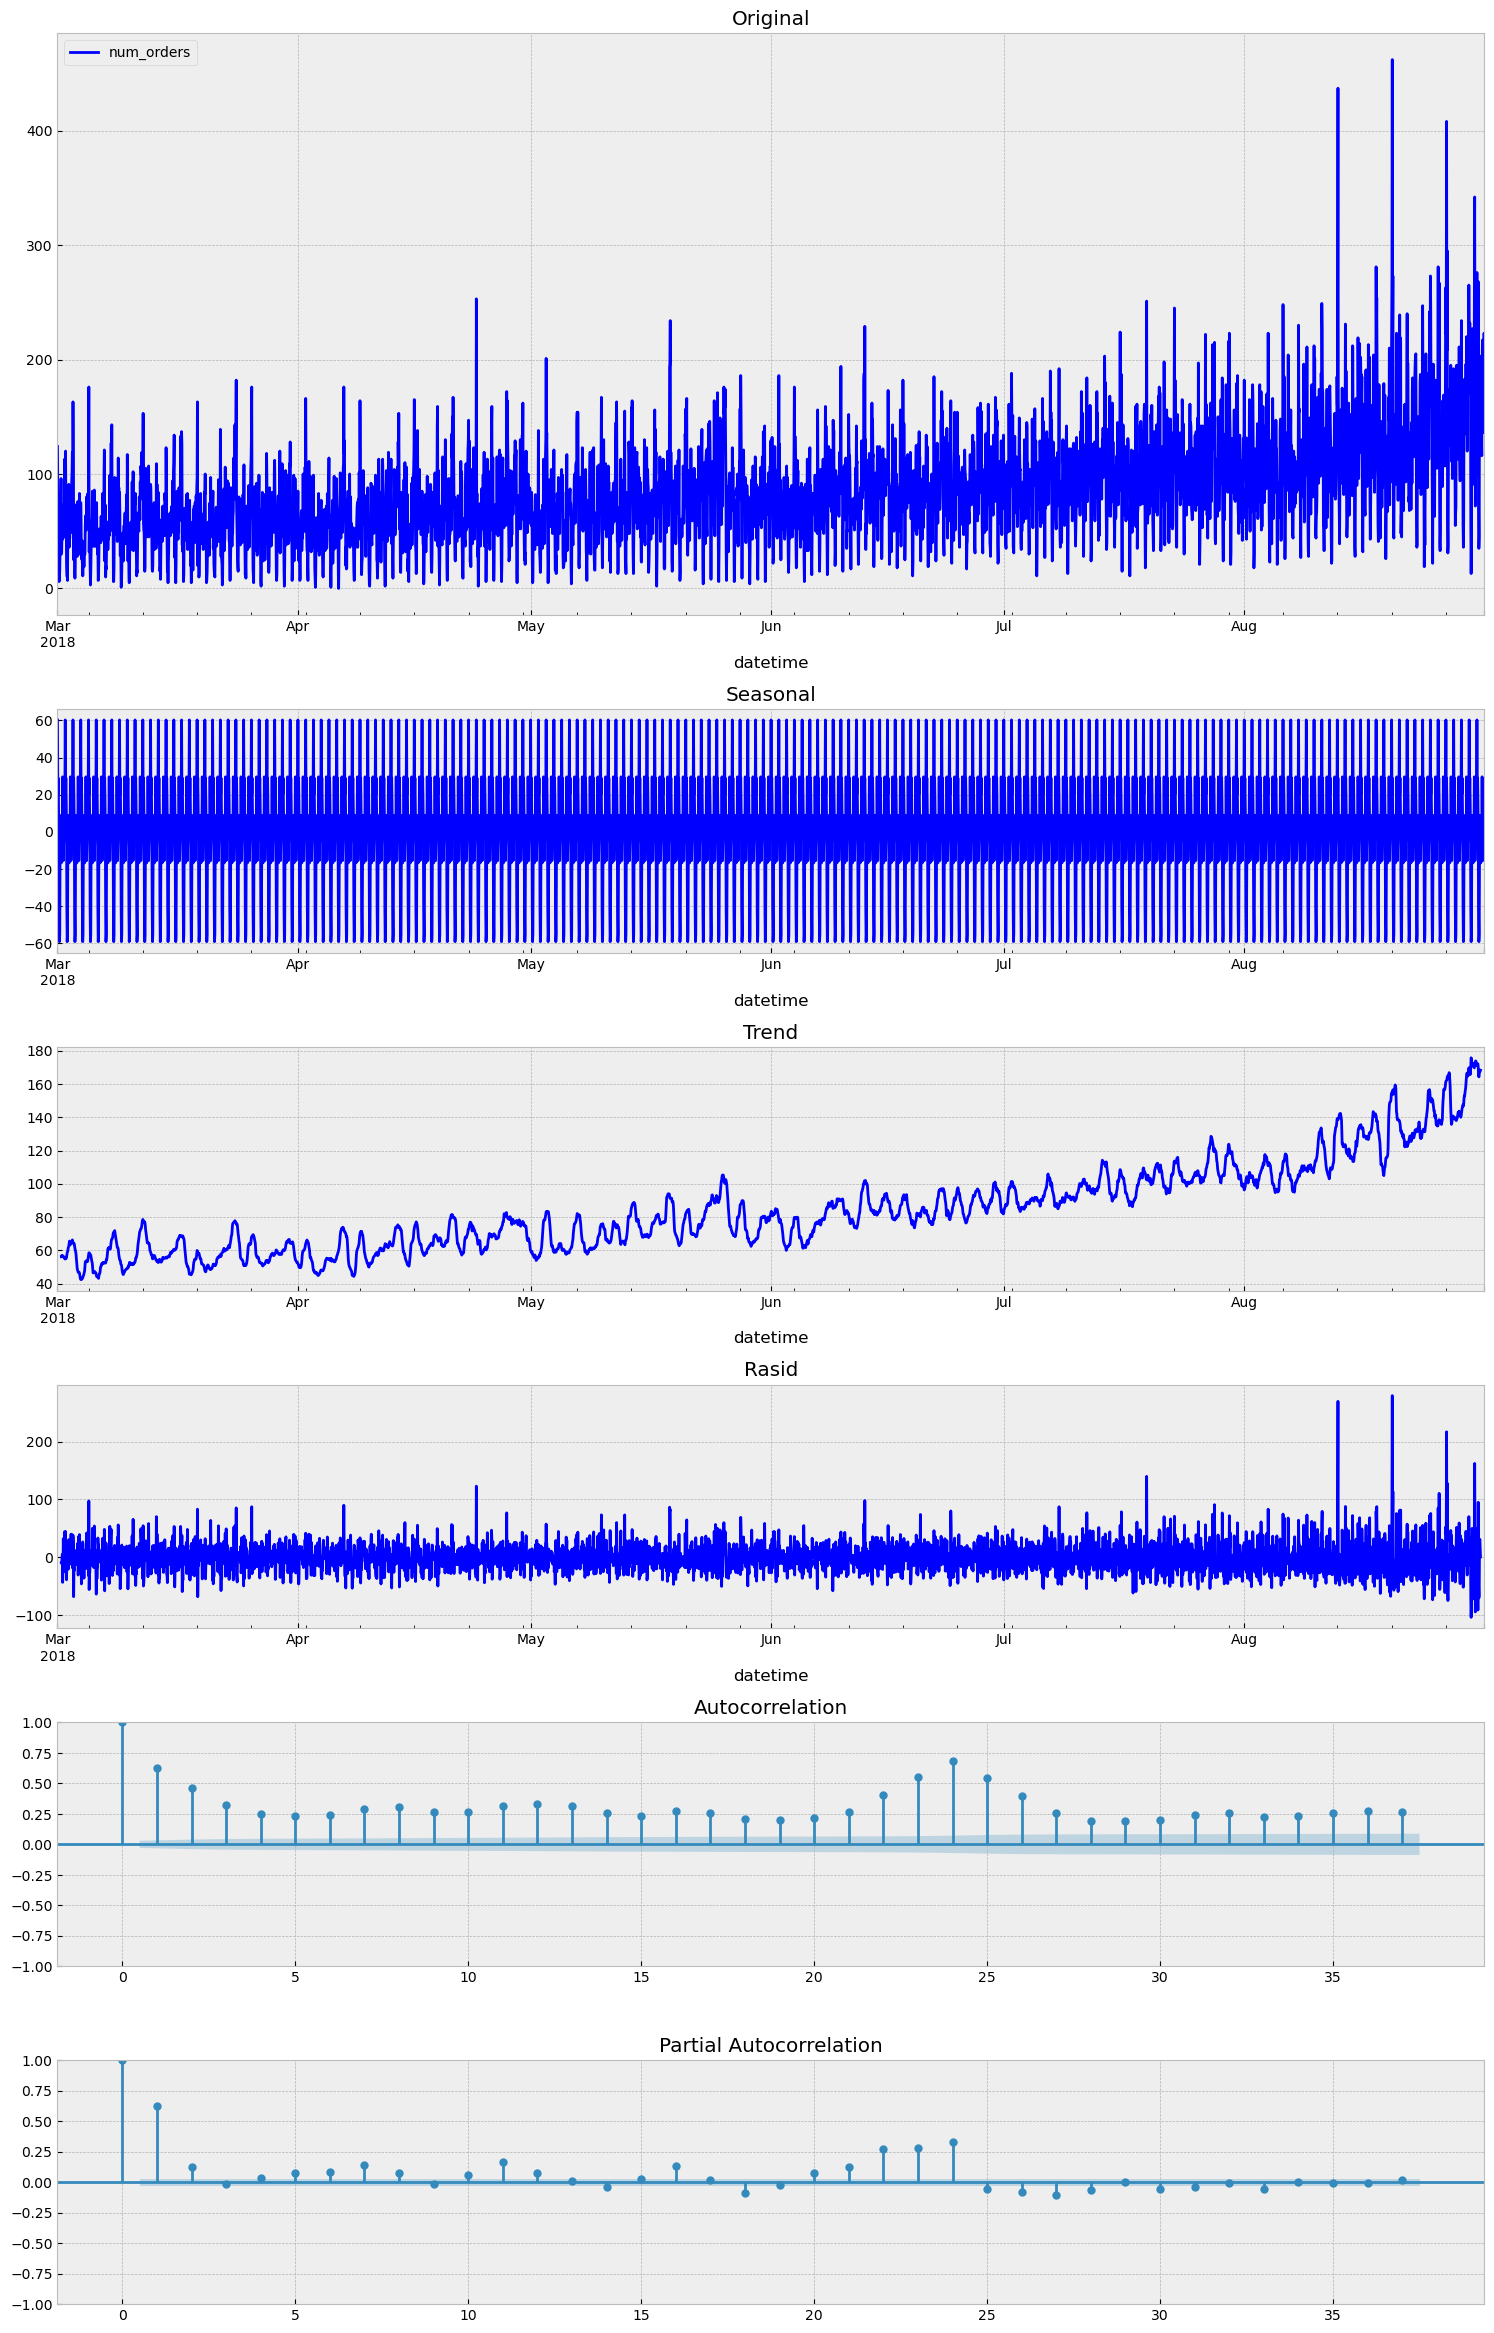

In [10]:
tsplot(data_1h)

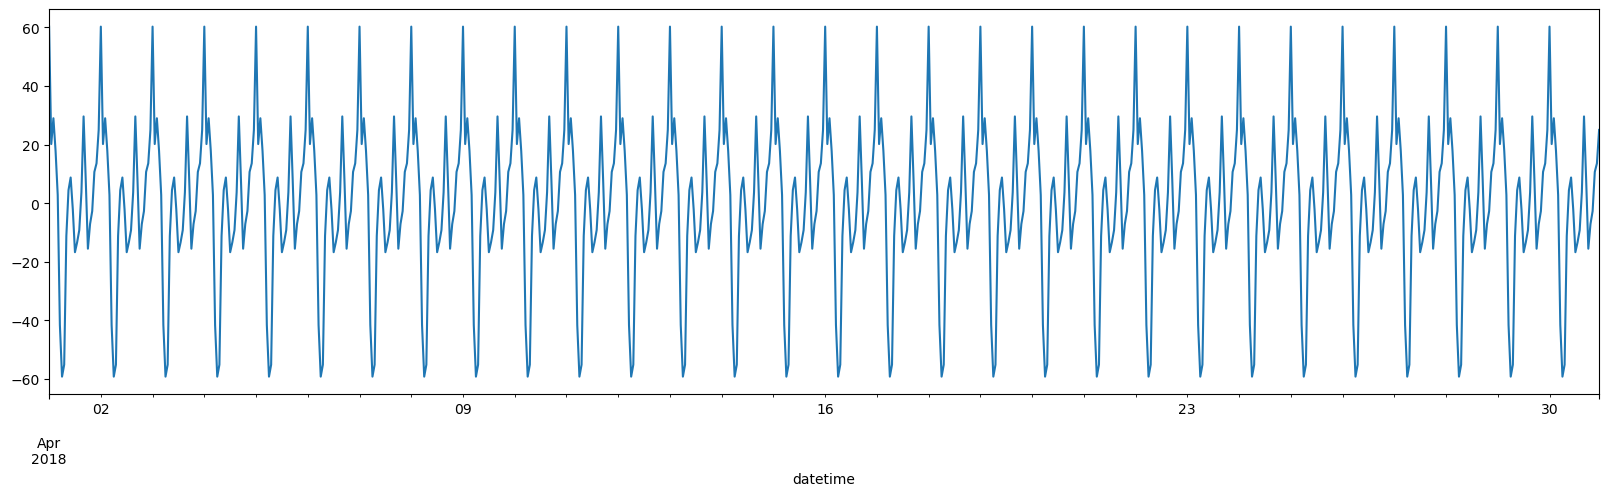

In [11]:
fig_day, ax_day = plt.subplots(1,1, figsize=(20, 5)) 
decomposed = seasonal_decompose(data_1h)
decomposed.seasonal['2018-04': '2018-04'].plot(ax=ax_day)
plt.show()

* Ситуация интересная, результат теста Дики-Фуллера зависит от выбранного порогового значения p-value (1% или 5%), но по графикам тренда и сезонности видно, что ряд нестационарный. Нулевую гипотезу не отвергаем.
* Тренд на увеличение количества заказов (не гладкий, медленно растущий).
* Шум довольно существенный.
* График автокорреляции, из-за наличия положительных значений на всем его протяжении, позволяет надеятся на то, что, созданные на основе лага фичи, будут иметь существенное влияние в дальнейших моделях.
* Отслеживается четкая суточная сезонность.

* Рассмотрим поближе случайную неделю.

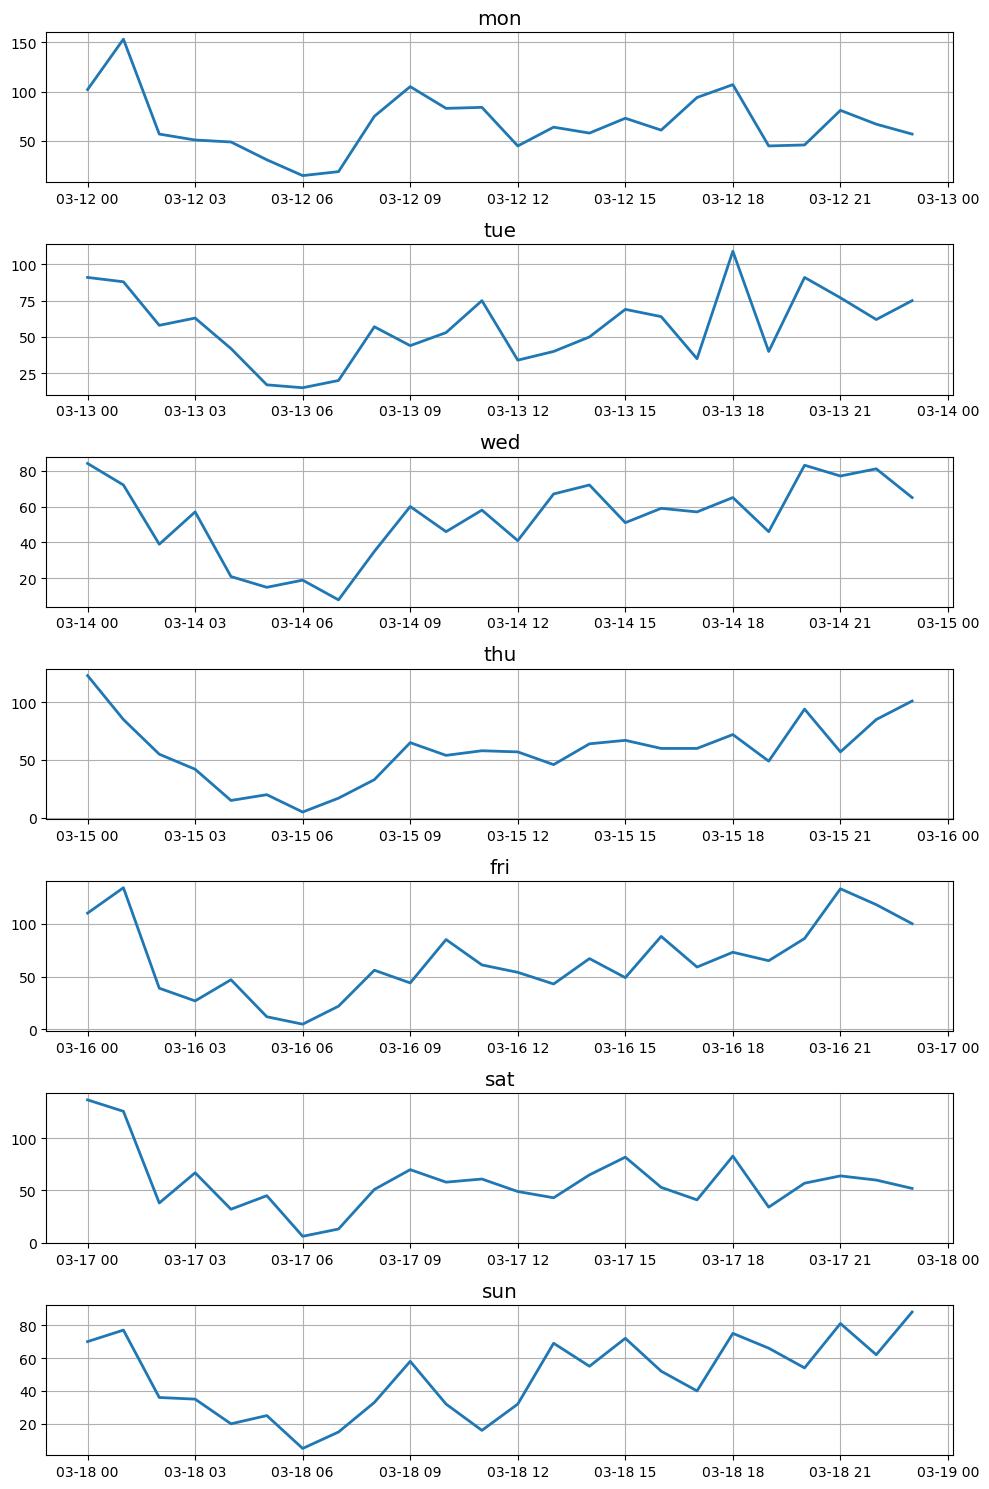

In [12]:
fig_week, ax_week = plt.subplots(7,1, figsize=(10, 15))
with plt.style.context(style='bmh'):
    for i in zip(range(7), ["mon", "tue", "wed", "thu", "fri", "sat", "sun"]):
        ax_week[i[0]].plot(data_1h[f'2018-03-{i[0]+12}': f'2018-03-{i[0]+12}'])
        ax_week[i[0]].set_title(i[1])
        ax_week[i[0]].grid()
    fig_week.tight_layout()
    plt.show()

Results of Dickey-Fuller Test:
Test Statistic                   3.728791
p-value                          1.000000
#Lags Used                      13.000000
Number of Observations Used    170.000000
Critical Value (1%)             -3.469413
Critical Value (5%)             -2.878696
Critical Value (10%)            -2.575917
dtype: float64


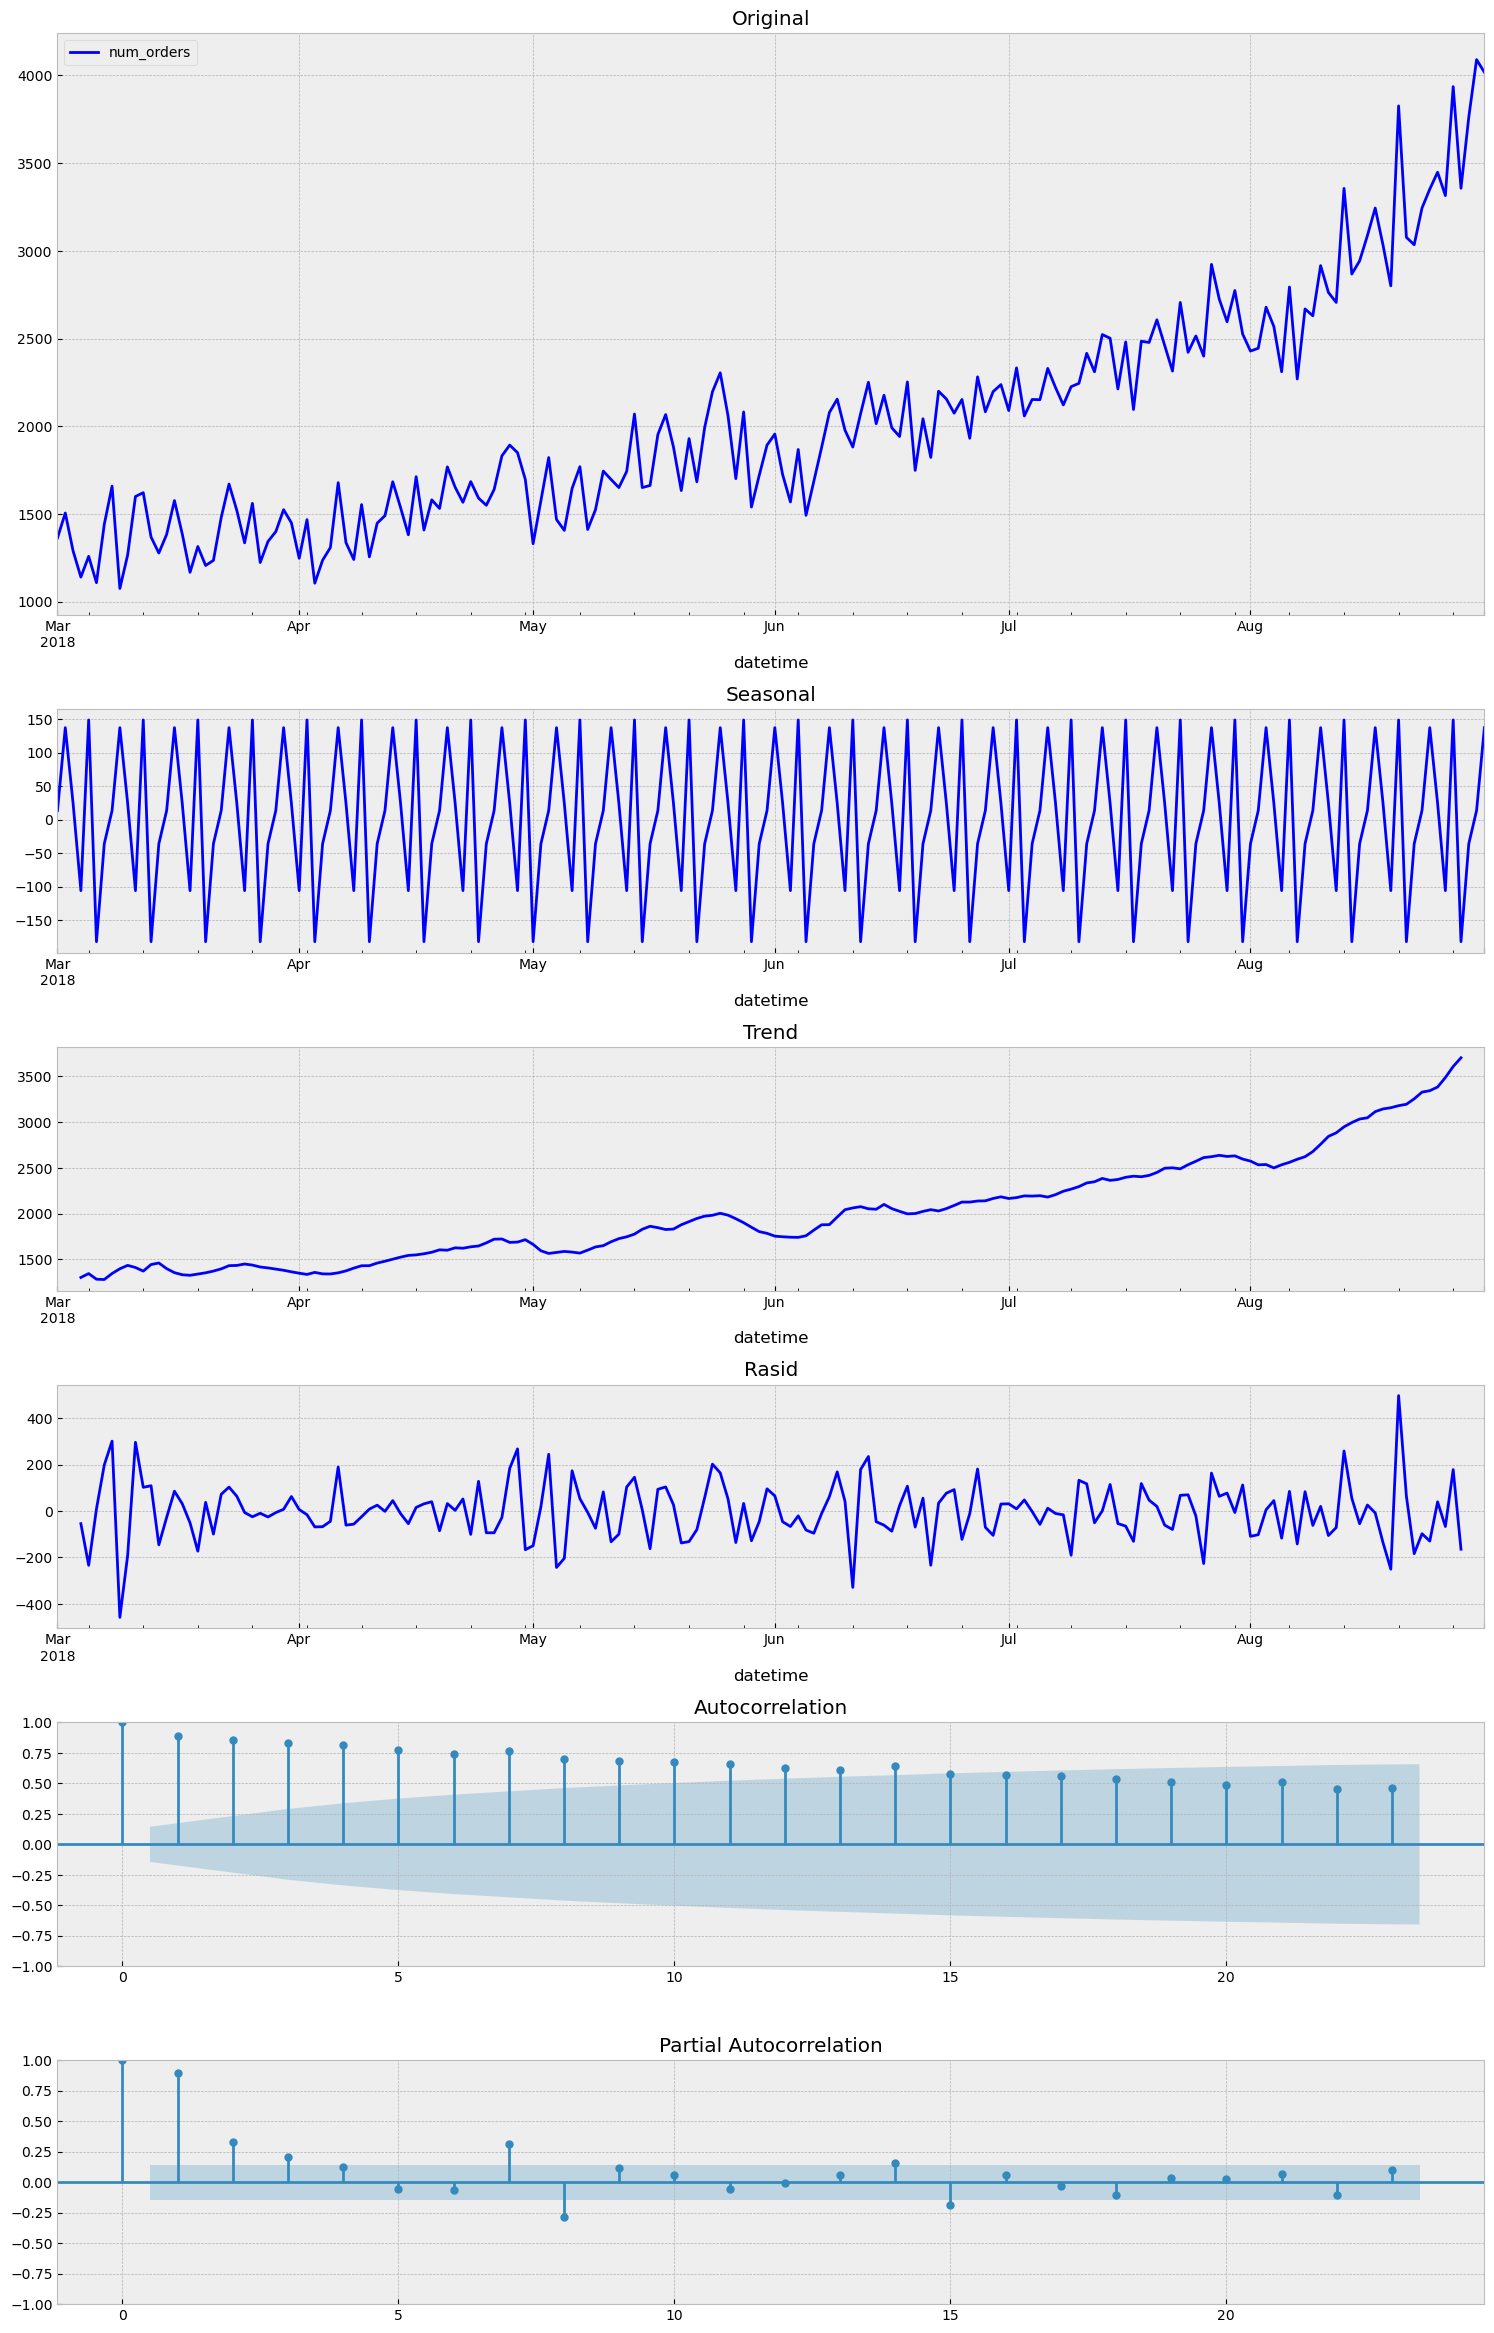

In [13]:
tsplot(data_1D)

* При ресемплировании по дням, отслеживается четкая периодичность по неделям.
* На неделе пики приходятся на понедельник и пятницу.
* В рабочие дни пики приходятся на время слегка за полночь, а также в районе 9 и 18 часов.
* Количество заказов увеличивается в пятницу, субботу и воскресение по вечерам.

## Обучение

### Создаем новые фичи

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range (1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [15]:
make_features(data_1h, 168, 168)

### Формируем выборки

In [16]:
data_1h = data_1h.dropna()

In [17]:
X = data_1h.drop('num_orders', axis=1)
y = data_1h['num_orders']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

### Обучаем модели

In [19]:
def plot_predict(y, y_pred):
    fig, ax = plt.subplots(2,1, figsize=(15, 10))
    with plt.style.context(style='bmh'):
        ax[0].plot(pd.Series(y), label = 'Real values')
        ax[0].plot(pd.Series(y_pred, index=y.index), label = 'Prediction')
        ax[0].set_title('Resample 1 hour')
        ax[0].legend()
        ax[0].grid()

        ax[1].plot(pd.Series(y).resample('1D').sum()[1:-2], label = 'Real values')
        ax[1].plot(pd.Series(y_pred, index=y.index).resample('1D').sum()[1:-2], label = 'Prediction')
        ax[1].set_title('Resample 1 day')
        ax[1].legend()
        ax[1].grid()

        fig.tight_layout()
        plt.show()

#### Линейная регрессия

In [20]:
lr = LinearRegression()

rmse_cv = -cross_val_score(estimator=lr, 
                              X=X_train, 
                              y=y_train, 
                              cv=TimeSeriesSplit(n_splits=5),  
                              scoring='neg_root_mean_squared_error')

val_score = rmse_cv.mean()
print(f'Средний RMSE: {rmse_cv.mean():.4f}')
print(f'RMSE по фолдам: {rmse_cv}')

Средний RMSE: 22.6899
RMSE по фолдам: [20.29756759 20.97387048 21.72561076 22.35031845 28.10219062]


In [21]:
#plot_predict(y_train, lr.predict(X_train))

#### Градиентный бустинг

In [22]:
lgbmr = LGBMRegressor()
rmse_cv = -cross_val_score(estimator=lgbmr, 
                              X=X_train, 
                              y=y_train, 
                              cv=TimeSeriesSplit(n_splits=5),  
                              scoring='neg_root_mean_squared_error')

print(f'Средний RMSE: {rmse_cv.mean():.4f}')
print(f'RMSE по фолдам: {rmse_cv}')

Средний RMSE: 23.3807
RMSE по фолдам: [20.01153755 21.7711243  22.57870387 22.32931984 30.2129191 ]


In [23]:
#plot_predict(y_train, lgbmr.predict(X_train))

* Линейная регрессия побеждает и по среднему значению RMSE, и по его разбросу по фолдам.

## Тестирование

In [24]:
best_model = lr
best_model.fit(X_train, y_train)
print(f'RMSE на тесте: {mean_squared_error(y_test, best_model.predict(X_test), squared=False):.4f}')

RMSE на тесте: 34.3188


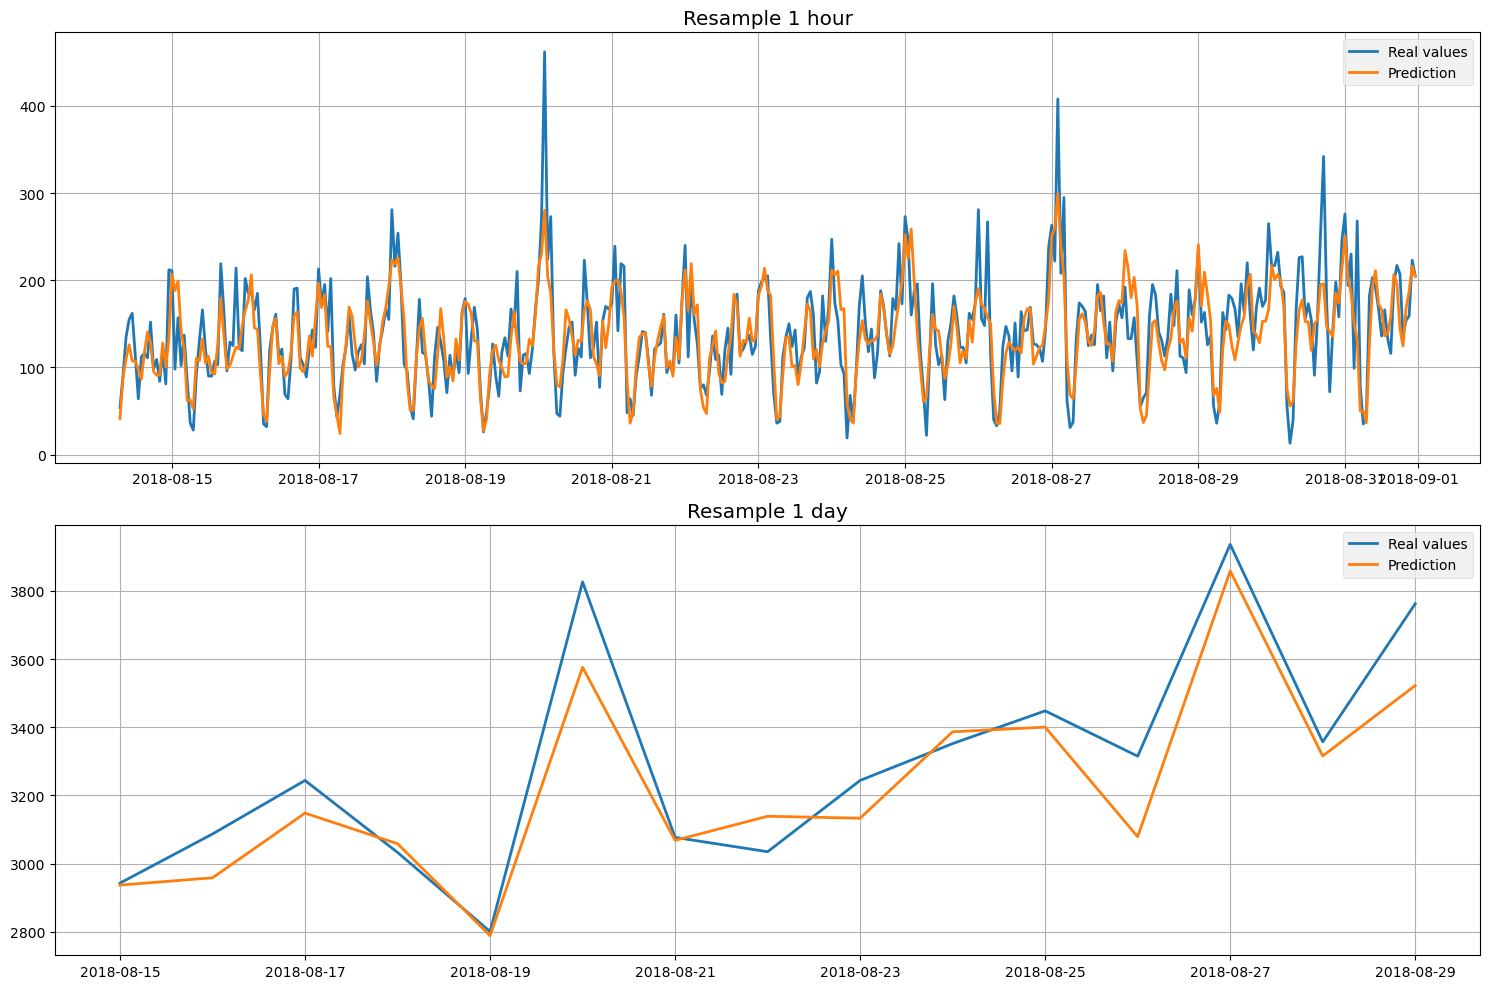

In [25]:
plot_predict(y_test, best_model.predict(X_test))

* Заданный показатель RMSE ниже 48 достигнут.

### Проверим модель на адекватность при помощи примитивных моделей (квадратичной функции, простой медианой)

In [26]:
data_func['new_index'] = range(len(data_func))
X_func = data_func['new_index']
y_func = data_func['num_orders']

X_train_func, X_test_func, y_train_func, y_test_func = train_test_split(X_func, y_func, test_size=0.1, shuffle=False)

In [27]:
class quadratic_func():
    def __init__(self, p_range, b_range):
        self.p_range = p_range
        self.b_range = b_range
        
    def fit(self, X, y):
        score= y.max()
        
        for p in self.p_range:
            for b in self.b_range:
                if mean_squared_error((X**2)/p+b, y, squared=False) < score:
                    score = mean_squared_error((X**2)/p+b, y, squared=False)
                    self.p = p
                    self.b = b
                
        return(score, self.p, self.b)
        
                
    def predict(self, X):
        return (X**2)/self.p+self.b

In [28]:
sf = quadratic_func(range(100000, 500000, 10000), range(50, 100, 10))

In [29]:
sf.fit(X_train_func, y_train_func)

(34.38934960200271, 280000, 60)

In [30]:
mean_squared_error(sf.predict(X_test_func), y_test_func, squared=False)

60.19457100522378

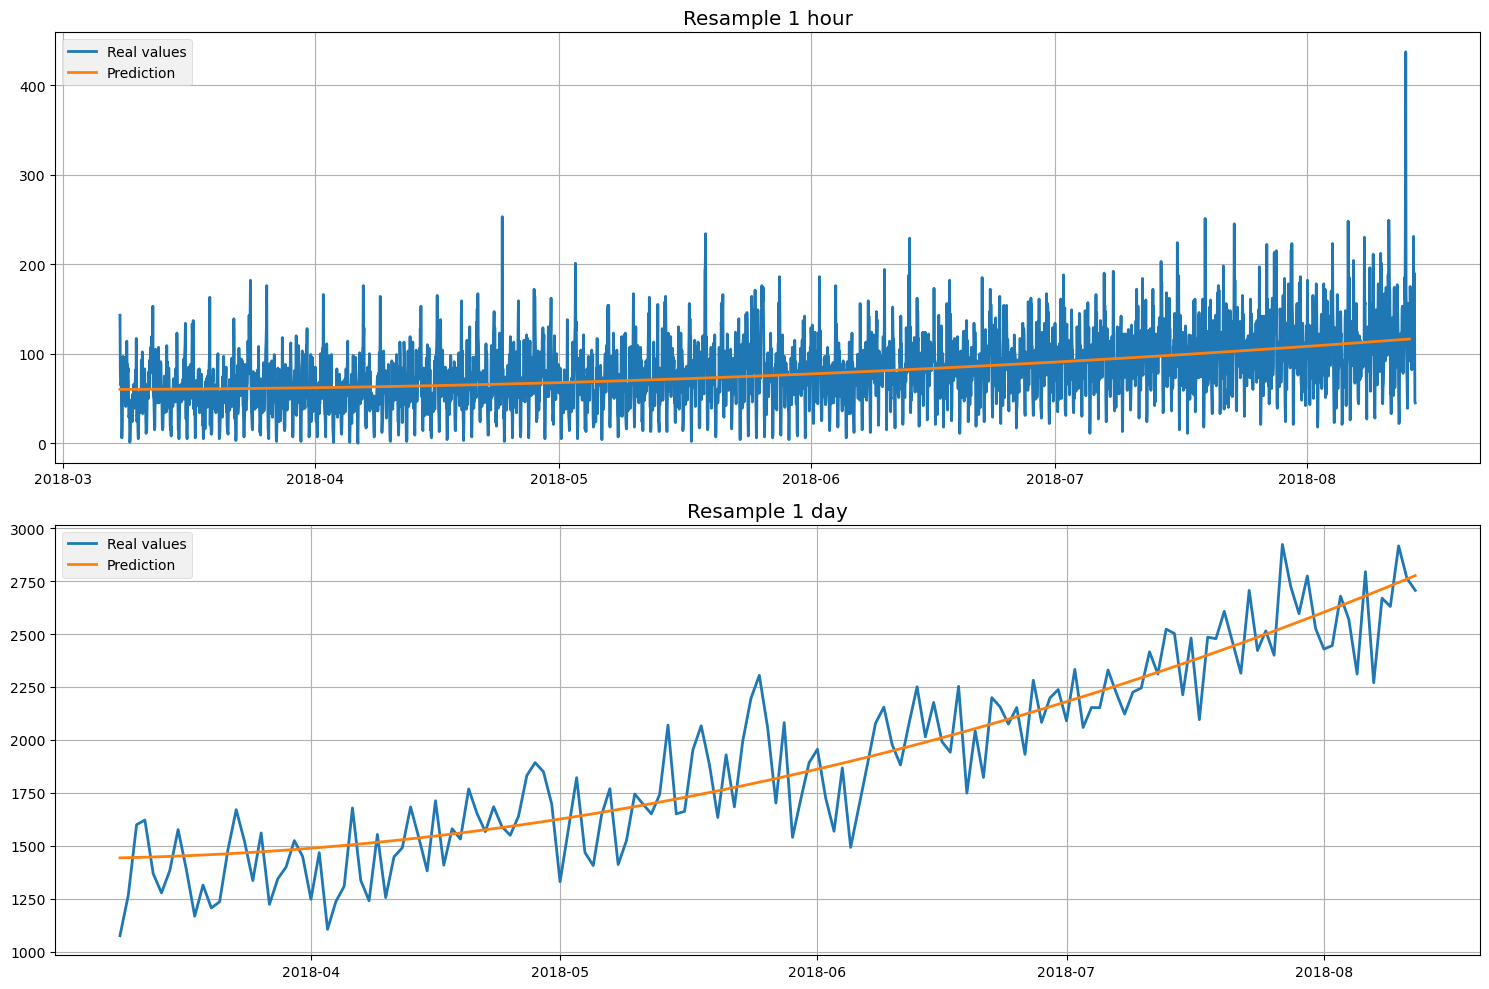

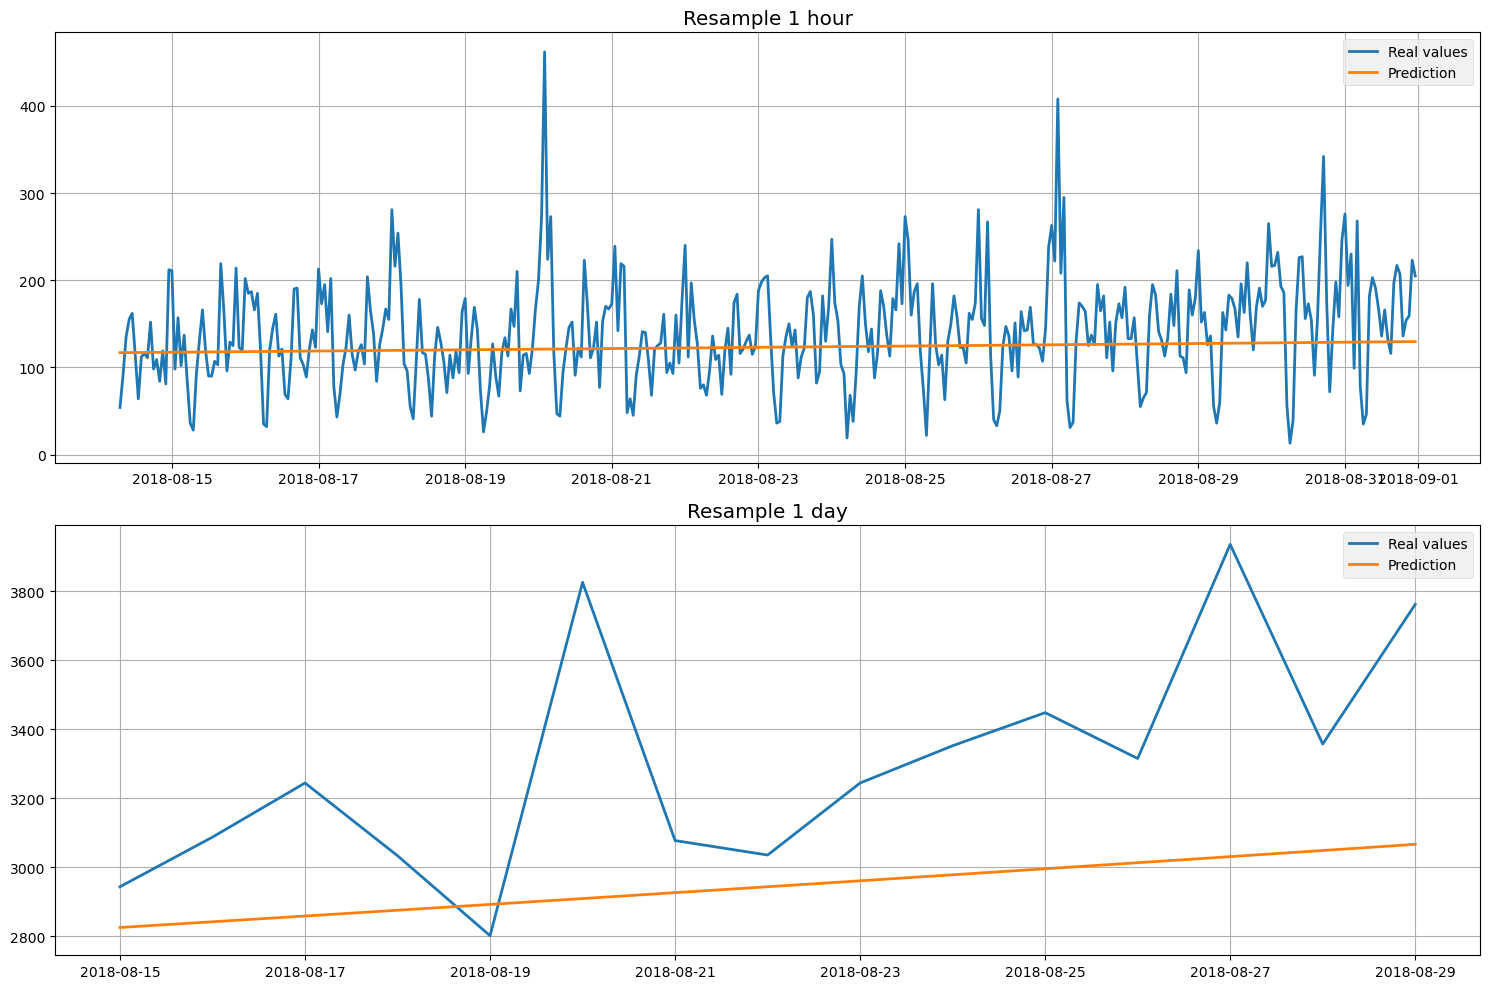

In [31]:
plot_predict(y_train, sf.predict(X_train_func))
plot_predict(y_test, sf.predict(X_test_func))

In [32]:
mean_squared_error(pd.Series([y_train_func.median()] * len(y_test_func)), y_test_func, squared=False)

87.15277582981295

* Ряд нестационарный.
* RMSE выбранной модели (LinearRegression) на тестовой выборке в 2-3 раза лучше, чем у моделей-заглушек.